In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, mean_squared_error
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

warnings.filterwarnings("ignore")


In [27]:
def load_dataset(scaler="minmax", strategy="split"):
    """
    Carrega os datasets NSL-KDD com duas estratégias:
    - 'split': carrega apenas o arquivo de treino e faz split em treino e validação
    - 'merge': carrega treino e teste reais e faz codificação alinhada
    """
    assert scaler in ["minmax", "standard"], "Escala inválida"
    assert strategy in ["split", "merge"], "Estratégia deve ser 'split' ou 'merge'"
    
    base_path = f"../data/final/{scaler}"
    train_path = f"{base_path}/KDDTrain+_final_{scaler}.csv"
    test_path = f"{base_path}/KDDTest+_final_{scaler}.csv"

    if strategy == "split":
        df = pd.read_csv(train_path)
        print(f"[SPLIT] Escala usada: {scaler}")
        print("Dataset carregado:", df.shape)

        # Split em treino e validação
        df_train, df_test = train_test_split(
            df, test_size=0.2, random_state=1, stratify=df["attack_category"]
        )
        print("Train split:", df_train.shape)
        print("Validação split:", df_test.shape)

        return df_train.reset_index(drop=True), df_test.reset_index(drop=True)

    else:  # strategy == "merge"
        df_train = pd.read_csv(train_path)
        df_test = pd.read_csv(test_path)

        df_train["__origin__"] = "train"
        df_test["__origin__"] = "test"

        df_all = pd.concat([df_train, df_test], axis=0)

        origin = df_all["__origin__"]
        target = df_all["attack_category"]
        df_all = df_all.drop(columns=["__origin__", "attack_category"])

        df_all = pd.get_dummies(df_all)
        df_all = df_all.fillna(0)

        df_all["attack_category"] = target.values
        df_all["__origin__"] = origin.values

        df_train_final = df_all[df_all["__origin__"] == "train"].drop(columns="__origin__")
        df_test_final = df_all[df_all["__origin__"] == "test"].drop(columns="__origin__")

        print(f"[MERGE] Escala usada: {scaler}")
        print("Train final:", df_train_final.shape)
        print("Test final :", df_test_final.shape)

        return df_train_final.reset_index(drop=True), df_test_final.reset_index(drop=True)

In [28]:
# minmax or standard
# Estratégia de split (KDDTrain+ somente)

df_train, df_val = load_dataset("minmax", strategy="split")

X_train = df_train.drop(columns=["attack_category"])
y_train = df_train["attack_category"]

X_val = df_val.drop(columns=["attack_category"])
y_val = df_val["attack_category"]

# Estratégia para avaliação final real (KDDTrain+ e KDDTest+ juntos)
df_train_final, df_test_final = load_dataset("minmax", strategy="merge")

X_train_final = df_train_final.drop(columns=["attack_category"])
y_train_final = df_train_final["attack_category"]

X_test_final = df_test_final.drop(columns=["attack_category"])
y_test_final = df_test_final["attack_category"]

[SPLIT] Escala usada: minmax
Dataset carregado: (125973, 62)
Train split: (100778, 62)
Validação split: (25195, 62)
[MERGE] Escala usada: minmax
Train final: (125973, 64)
Test final : (22544, 64)


## 1. Logistic Regression

## 2. Preparação dos Dados

Treinamento da Logistic Regression


In [29]:
# Define uma semente aleatória para garantir a reprodutibilidade dos resultados.
np.random.seed(1)

# Cria uma instância do LabelEncoder, que serve para transformar variáveis categóricas (no caso, os rótulos de classes)
# em números inteiros
le = LabelEncoder()

# Aplica o fit_transform no conjunto de treino:
y_train_enc = le.fit_transform(y_train)

# Transforma o conjunto de validação usando o mesmo "mapeamento" aprendido no fit do treino.
# Isso garante que os rótulos do conjunto de validação sejam codificados de forma consistente.
y_val_enc = le.transform(y_val)


In [30]:

# Modelo base
lr = LogisticRegression(
    penalty='l2',   # Regularização padrão
    C=1.0,          # Força da regularização inversa
    solver='lbfgs', # Solver adequado para multiclasse
    multi_class='ovr',
    max_iter=1000,
    random_state=1
)

# Treinamento
lr.fit(X_train, y_train_enc)

# Predição
y_pred = lr.predict(X_val)

# Avaliação
print("Acurácia:", accuracy_score(y_val_enc, y_pred))
print(classification_report(
    y_val_enc,
    y_pred,
    target_names=le.classes_,
    digits=4
))


Acurácia: 0.97364556459615
              precision    recall  f1-score   support

         DoS     0.9887    0.9786    0.9836      9186
       Probe     0.9600    0.9365    0.9481      2331
         R2L     0.6992    0.4673    0.5602       199
         U2R     0.4000    0.2000    0.2667        10
      normal     0.9688    0.9848    0.9767     13469

    accuracy                         0.9736     25195
   macro avg     0.8033    0.7134    0.7471     25195
weighted avg     0.9729    0.9736    0.9730     25195



In [ ]:
from itertools import product

C_list = [0.01, 0.1, 1.0, 10, 100]
solver_list = ['lbfgs', 'saga', 'newton-cg']

results = []
i = 0

for C, solver in product(C_list, solver_list):
    # Criação do modelo Logistic Regression com a combinação atual de hiperparâmetros
    lr = LogisticRegression(
        penalty='l2',           # Regularização L2 padrão
        C=C,                   # Valor atual do hiperparâmetro de regularização
        solver=solver,         # Algoritmo de otimização atual
        multi_class='ovr',     # Estratégia One-vs-Rest para problemas multiclasse
        max_iter=1000,         # Número máximo de iterações (para garantir convergência)
        random_state=1         # Seed fixa para reprodutibilidade
    )

    
    try:
        
        lr.fit(X_train, y_train_enc)  # Treina o modelo com os dados de treino
        y_pred = lr.predict(X_val)    # Faz as previsões no conjunto de validação

        # Calcula as métricas de avaliação
        acc = accuracy_score(y_val_enc, y_pred)  # Acurácia: proporção de classificações corretas
        f1 = f1_score(y_val_enc, y_pred, average='macro')  # F1-score macro: média entre as classes


        # Armazena os resultados da combinação atual
        results.append({
            'C': C,                     # Valor de C usado
            'solver': solver,           # Solver usado
            'accuracy': acc,            # Acurácia obtida
            'f1_macro': f1              # F1 macro obtido
        })


        i += 1
    except Exception as e:
        print(f"Erro com C={C}, solver={solver}: {e}")

print(f"Testadas {i} combinações de hiperparâmetros")

df_results = pd.DataFrame(results)
df_sorted = df_results.sort_values(by='f1_macro', ascending=False).reset_index(drop=True)
print(df_sorted.head(10))


Testadas 15 combinações de hiperparâmetros
       C     solver  accuracy  f1_macro
0  100.0       saga  0.978527  0.790270
1  100.0  newton-cg  0.978448  0.784419
2   10.0      lbfgs  0.976106  0.783772
3  100.0      lbfgs  0.977019  0.782102
4   10.0  newton-cg  0.976225  0.779927
5   10.0       saga  0.976225  0.779248
6    1.0  newton-cg  0.973765  0.751605
7    1.0       saga  0.973725  0.750995
8    1.0      lbfgs  0.973646  0.747065
9    0.1       saga  0.970907  0.614352


## Melhor Modelo

In [32]:
best_lr = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='lbfgs',
    multi_class='ovr',
    max_iter=1000,
    random_state=1
)

best_lr.fit(X_train, y_train_enc)

y_pred = best_lr.predict(X_val)

# Métricas
accuracy = accuracy_score(y_val_enc, y_pred)
precision = precision_score(y_val_enc, y_pred, average='macro')
recall = recall_score(y_val_enc, y_pred, average='macro')
f1 = f1_score(y_val_enc, y_pred, average='macro')
rmse = np.sqrt(mean_squared_error(y_val_enc, y_pred))

print("\n==== Avaliação Final - Logistic Regression (Validação) ====")
print(f"{'Acurácia:':<30} {accuracy:.4f}")
print(f"{'F1-score (macro):':<30} {f1:.4f}")
print(f"{'Precisão (macro):':<30} {precision:.4f}")
print(f"{'Recall (macro / TPR):':<30} {recall:.4f}")
print(f"{'RMSE:':<30} {rmse:.4f}")



==== Avaliação Final - Logistic Regression (Validação) ====
Acurácia:                      0.9736
F1-score (macro):              0.7471
Precisão (macro):              0.8033
Recall (macro / TPR):          0.7134
RMSE:                          0.5210


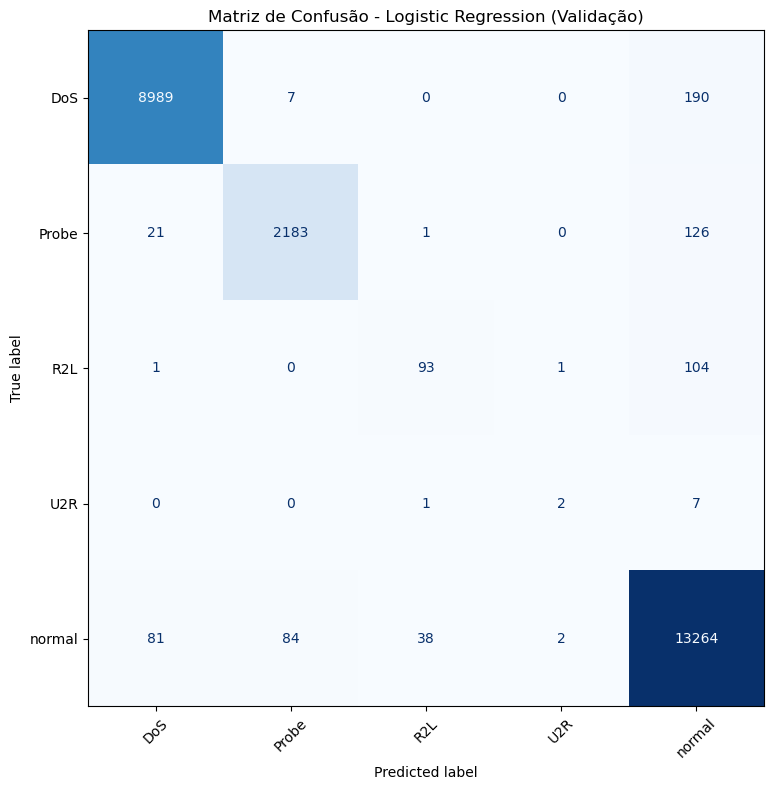

In [33]:
labels = sorted(le.classes_)
cm = confusion_matrix(y_val_enc, y_pred)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", xticks_rotation=45, ax=ax, colorbar=False)
plt.title("Matriz de Confusão - Logistic Regression (Validação)")
plt.grid(False)
plt.tight_layout()
plt.show()


### Avaliação do Melhor Modelo

==== Relatório Binário (normal vs attack) ====
              precision    recall  f1-score   support

      normal     0.9688    0.9848    0.9767     13469
      attack     0.9822    0.9636    0.9728     11726

    accuracy                         0.9749     25195
   macro avg     0.9755    0.9742    0.9748     25195
weighted avg     0.9750    0.9749    0.9749     25195



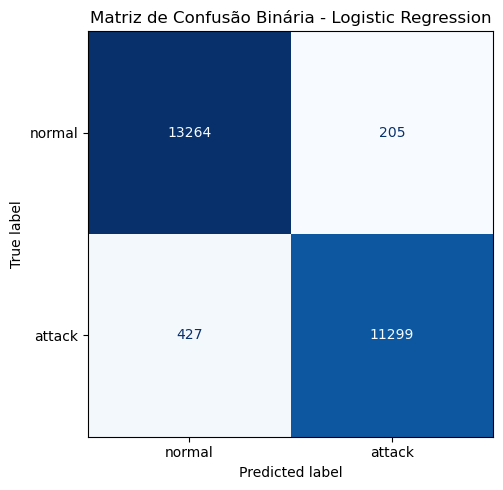

In [34]:
y_val_labels = le.inverse_transform(y_val_enc)
y_pred_labels = le.inverse_transform(y_pred)

y_val_bin = pd.Series(y_val_labels).apply(lambda x: 0 if x == "normal" else 1)
y_pred_bin = pd.Series(y_pred_labels).apply(lambda x: 0 if x == "normal" else 1)

print("==== Relatório Binário (normal vs attack) ====")
print(classification_report(y_val_bin, y_pred_bin, target_names=["normal", "attack"], digits=4))

cm_bin = confusion_matrix(y_val_bin, y_pred_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bin, display_labels=["normal", "attack"])

fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap="Blues", ax=ax, colorbar=False)
plt.title("Matriz de Confusão Binária - Logistic Regression")
plt.grid(False)
plt.tight_layout()
plt.show()


## Avaliação Final no Conjunto de Teste Real (KDDTest+)

O modelo DT selecionado é treinado com todos os dados de treino e avaliado no conjunto de teste real (`KDDTest+`). 


In [35]:
y_train_enc = le.fit_transform(y_train_final)
y_test_enc = le.transform(y_test_final)

best_lr.fit(X_train_final, y_train_enc)
y_pred = best_lr.predict(X_test_final)

accuracy = accuracy_score(y_test_enc, y_pred)
precision = precision_score(y_test_enc, y_pred, average='macro')
recall = recall_score(y_test_enc, y_pred, average='macro')
f1 = f1_score(y_test_enc, y_pred, average='macro')
rmse = np.sqrt(mean_squared_error(y_test_enc, y_pred))

print("\n==== Avaliação Final - Logistic Regression (KDDTrain+ vs KDDTest+) ====")
print(f"{'Acurácia:':<30} {accuracy:.4f}")
print(f"{'F1-score (macro):':<30} {f1:.4f}")
print(f"{'Precisão (macro):':<30} {precision:.4f}")
print(f"{'Recall (macro / TPR):':<30} {recall:.4f}")
print(f"{'RMSE:':<30} {rmse:.4f}")



==== Avaliação Final - Logistic Regression (KDDTrain+ vs KDDTest+) ====
Acurácia:                      0.7314
F1-score (macro):              0.4607
Precisão (macro):              0.7333
Recall (macro / TPR):          0.4680
RMSE:                          1.4649


### Relatório

Gera relatório de precisão, recall e F1-score para cada categoria no conjunto de teste real.

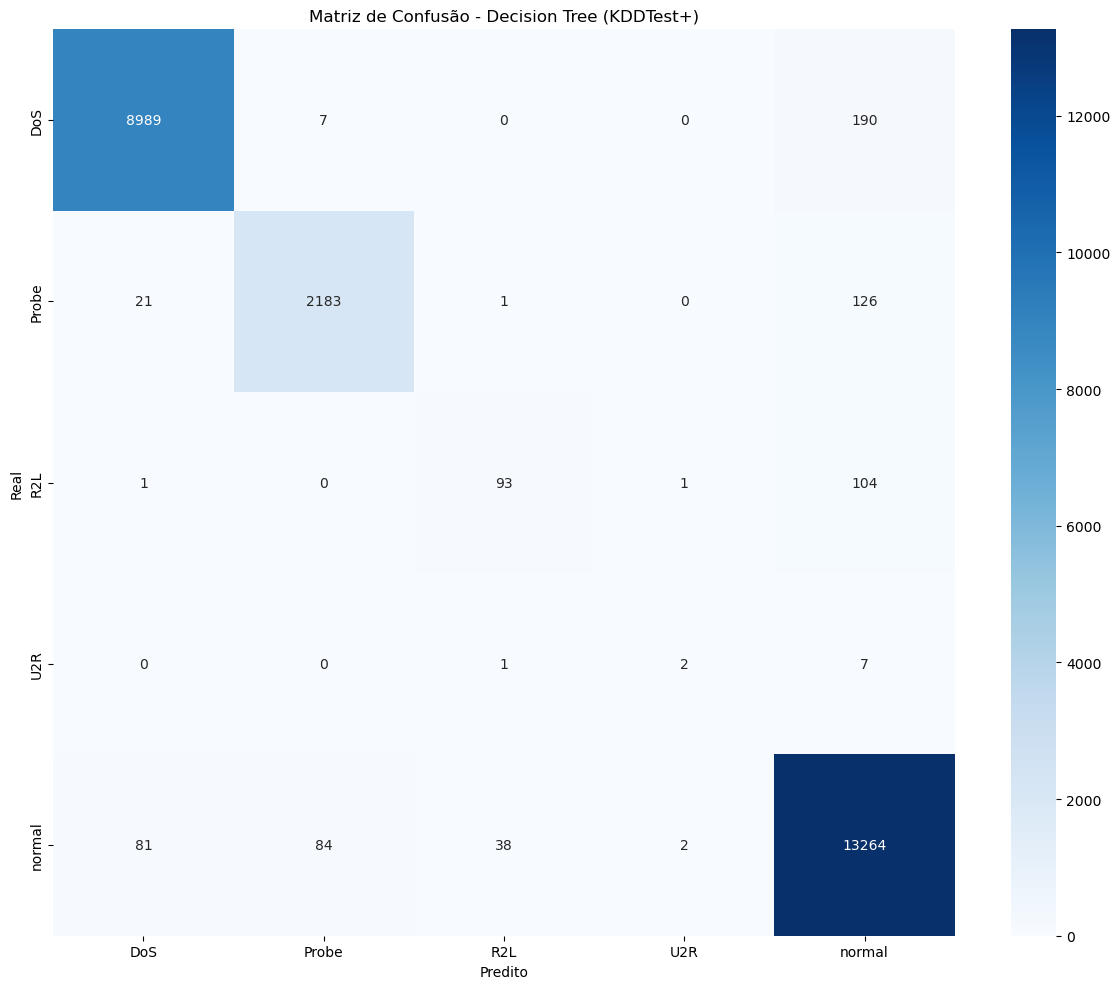

              precision    recall  f1-score       support
DoS            0.959943  0.812953  0.880354   7458.000000
Probe          0.688420  0.579513  0.629289   2421.000000
R2L            0.882353  0.005196  0.010331   2887.000000
U2R            0.500000  0.014925  0.028986     67.000000
normal         0.635594  0.927505  0.754292   9711.000000
accuracy       0.731414  0.731414  0.731414      0.731414
macro avg      0.733262  0.468018  0.460650  22544.000000
weighted avg   0.779765  0.731414  0.685144  22544.000000
              precision    recall  f1-score       support
normal         0.635594  0.927505  0.754292   9711.000000
attack         0.915920  0.597600  0.723286  12833.000000
accuracy       0.739709  0.739709  0.739709      0.739709
macro avg      0.775757  0.762552  0.738789  22544.000000
weighted avg   0.795167  0.739709  0.736642  22544.000000


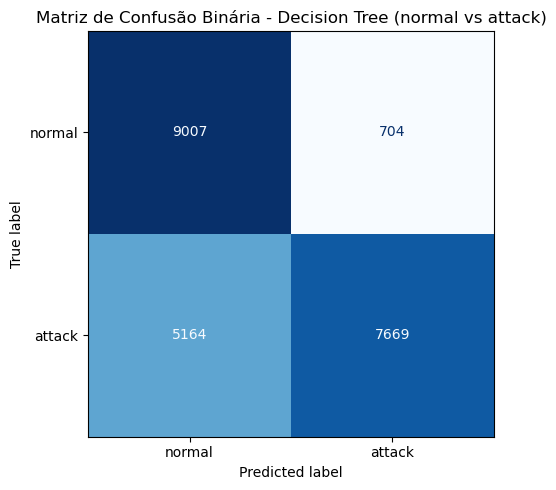

In [36]:

# Visualização da matriz de confusão multiclasse
plt.figure(figsize=(12, 10))  # Define o tamanho da figura
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  # Cria um mapa de calor com os valores inteiros
            xticklabels=le.classes_, yticklabels=le.classes_)  # Usa as classes originais como rótulos
plt.xlabel('Predito')  # Define o nome do eixo x
plt.ylabel('Real')  # Define o nome do eixo y
plt.title('Matriz de Confusão - Decision Tree (KDDTest+)')  # Título do gráfico
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()  # Exibe o gráfico

# Relatório detalhado por classe

# Converte os rótulos numéricos de teste e predição para as classes originais
y_test_labels = le.inverse_transform(y_test_enc)
y_pred_labels = le.inverse_transform(y_pred)

# Gera o relatório de classificação com precisão, recall e F1-score por classe
report_dict = classification_report(
    y_test_labels,
    y_pred_labels,
    output_dict=True,  # Retorna o relatório como dicionário para posterior manipulação
    digits=4  # Define a precisão de 4 casas decimais
)

# Converte o relatório para um DataFrame para visualização tabular
report_df = pd.DataFrame(report_dict).transpose()
print(report_df)  # Exibe o DataFrame com as métricas por classe

# Avaliação binária (normal vs ataque)

# Transforma as classes em binárias: 0 para "normal", 1 para qualquer outro tipo de ataque
y_test_bin = pd.Series(y_test_labels).apply(lambda x: 0 if x == "normal" else 1)
y_pred_bin = pd.Series(y_pred_labels).apply(lambda x: 0 if x == "normal" else 1)

# Gera o relatório de classificação binária
report_bin = classification_report(
    y_test_bin,
    y_pred_bin,
    target_names=["normal", "attack"],  # Define os nomes das classes para o relatório
    digits=4,
    output_dict=True
)

# Converte o relatório binário para DataFrame
report_bin_df = pd.DataFrame(report_bin).transpose()
print(report_bin_df)  # Exibe as métricas binárias

# Gera e plota a matriz de confusão binária
cm_bin = confusion_matrix(y_test_bin, y_pred_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bin, display_labels=["normal", "attack"])

# Visualização da matriz de confusão binária
fig, ax = plt.subplots(figsize=(6, 5))  # Define o tamanho da figura
disp.plot(cmap="Blues", ax=ax, colorbar=False)  # Plota a matriz com mapa de calor azul
plt.title("Matriz de Confusão Binária - Decision Tree (normal vs attack)")  # Título
plt.grid(False)  # Remove a grade do gráfico
plt.tight_layout()  # Ajusta layout
plt.show()  # Exibe o gráfico
